In [1]:
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Cargar la capa de manzanas de las ciudades desde el GPKG
path_to_gpkg = r"C:\Users\ADMIN\Desktop\Ejercicio\Localidad\Loc_Tipologías_NAC.gpkg"
manzanas = gpd.read_file(path_to_gpkg, layer='Loc_SubTipologias')

In [3]:
def create_square_grid(bounds, cell_size):
    minx, miny, maxx, maxy = bounds
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    squares = []
    for x in x_coords:
        for y in y_coords:
            square = box(x, y, x + cell_size, y + cell_size)
            squares.append(square)
    return squares


cell_size = 500  # Tamaño de la celda en metros

# Ajustar CRS de las manzanas para que las distancias estén en metros
manzanas = manzanas.to_crs(epsg=6372)

# Generar la cuadrícula de cuadrados para cada metrópoli
square_grid_gdfs = []
for metropoli in manzanas['NOM_MET'].unique():
    # Obtener los límites de la metrópoli
    metropoli_manzanas = manzanas[manzanas['NOM_MET'] == metropoli]
    bounds = metropoli_manzanas.total_bounds
    
    # Generar la cuadrícula de cuadrados
    square_grid = create_square_grid(bounds, cell_size)
    
    # Crear un GeoDataFrame con la cuadrícula de cuadrados
    square_grid_gdf = gpd.GeoDataFrame({'geometry': square_grid}, crs=manzanas.crs)
    
    # Intersectar los cuadrados con las manzanas de la metrópoli
    hex_intersect = gpd.sjoin(square_grid_gdf, metropoli_manzanas, how='inner', op='intersects')
    
    # Guardar el resultado
    square_grid_gdfs.append(hex_intersect)

# Combinar los GeoDataFrames de todas las metrópolis
square_grid_final = gpd.GeoDataFrame(pd.concat(square_grid_gdfs, ignore_index=True), crs=manzanas.crs)

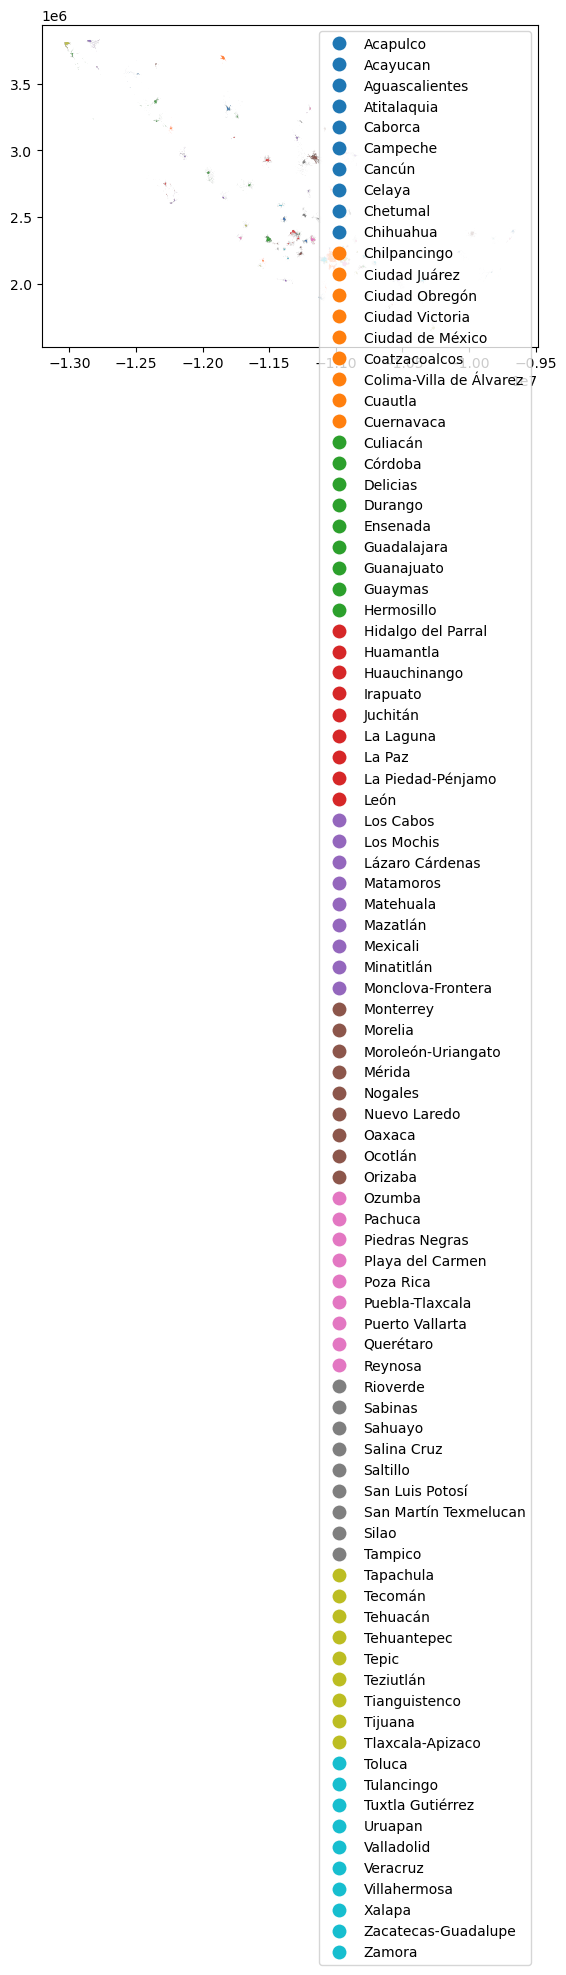

In [4]:
square_grid_final.to_file(r"C:\Users\ADMIN\Desktop\Ejercicio\Cuadrícula_Hexagonal.gpkg", driver="GPKG")

In [5]:
square_grid_final.plot(column='NOM_MET', legend=True)
plt.show()